In [1]:
import nest_asyncio
nest_asyncio.apply()

ONLY USE THIS FILE IF TRANSFER LEARNING TENSOR IS RAN PRIOR
    Load the 3 saved torch files. Can train directly from this point

In [2]:
import torch

# Load the datasets
train_set = torch.load('Btrain_set.pt')
validation_set = torch.load('Bvalidation_set.pt')
test_set = torch.load('Btest_set.pt')

In [3]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image

In [4]:
n = 10

class preLearnedFungaV1(nn.Module):
    def __init__(self):
        super(preLearnedFungaV1, self).__init__()
        self.name = "fungaV1"
        #added anther convolution channel before fc layers
        self.conv1 = nn.Conv2d(256, 128, 3, 1, 1)
        self.fc1 = nn.Linear(128*6*6, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, n)

        #dropout implementation
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)
        self.dropout4 = nn.Dropout(0.1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)

        #FC layers
        x = self.dropout2(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout3(x)
        x = F.relu(self.fc2(x))

        x = self.dropout4(x)
        x = self.fc3(x)
        x = x.squeeze(1)  
        return x

In [5]:
def dataLoadFunction(BatchSize):
  train_load = torch.utils.data.DataLoader(train_set, batch_size = BatchSize, shuffle=True)
  validation_load = torch.utils.data.DataLoader(validation_set, batch_size = BatchSize)
  testing_load = torch.utils.data.DataLoader(test_set, batch_size = BatchSize)
  return train_load, validation_load, testing_load

In [6]:
def getValidationLoss(net, validation_loader, criterion):
  totalLoss = 0
  count = 0
  for data in validation_loader:
    inputs, labels = data
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    totalLoss += loss.item()
    count += inputs.size(0)
  totalLoss = totalLoss / count
  return totalLoss


#model name
def get_model_name(name, batch_size, lr, epoch):
    path = "modelStorage/model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, lr, epoch)
    return path

#plotting helper function
import matplotlib.pyplot as plt
#plot image function
#modified from lab 2
def plot_training_curve(path):
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    n = len(train_loss)
    #plot model
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [22]:
import time
def train_net_TL(net, batchsize=24, learning_rate=0.007, num_epochs=12, weight_decay=0): #values here are defaults, should* be overwritten when called

  torch.manual_seed(1)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.8, weight_decay = weight_decay)

  training_loader, validation_loader, _ = dataLoadFunction(batchsize)

  train_loss_graph = np.zeros(num_epochs)
  val_loss_graph = np.zeros(num_epochs)

  totalHere = 0
  startTime = time.time()
  for currepoch in range(num_epochs):
    #print("New epoch")
    trainLoss = 0
    net.train()
    for i, (inputs, labels) in enumerate(training_loader):
      optimizer.zero_grad()

      inputs = torch.tensor(inputs.detach().numpy()).to(inputs.device)
      outputs = net(inputs)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      trainLoss += loss.item()
      totalHere += inputs.size(0)

    #print("Onto validation")
    net.eval()
    train_loss_graph[currepoch] = trainLoss/totalHere
    val_loss_graph[currepoch] = getValidationLoss(net, validation_loader, criterion)
    if (currepoch % 5 == 0):
      print(f"Epoch: {currepoch} Training Loss: {train_loss_graph[currepoch]:.6f}, Validation Loss: {val_loss_graph[currepoch]:.6f}, Time: {time.time() - startTime:.2f} seconds")
      model_path = get_model_name(net.name, batchsize, learning_rate, currepoch)
      torch.save(net.state_dict(), model_path)
      np.savetxt("{}_train_loss.csv".format(model_path), train_loss_graph)
      np.savetxt("{}_val_loss.csv".format(model_path), val_loss_graph)
  print("Total time: ", time.time()-startTime)

  path = "modelStorage/model_{0}_bs{1}_lr{2}_epoch{3}".format(net.name, batchsize, learning_rate, num_epochs)
  np.savetxt("{}_train_loss.csv".format(path), train_loss_graph)
  np.savetxt("{}_val_loss.csv".format(path), val_loss_graph)

In [20]:
#global variabls - so you don't have to modify them everywhere
BATCH_SIZE = 36
NUM_EPOCHS = 21
LEARNING_RATE = 0.007

#With Weight Decay
WEIGHTDECAY = 0

In [9]:
n = 10

In [ ]:
net3TL = preLearnedFungaV1()
#train_net_TL(net3TL, batchsize=BATCH_SIZE, num_epochs=NUM_EPOCHS)

train_net_TL(net3TL, batchsize=BATCH_SIZE, num_epochs=NUM_EPOCHS, learning_rate = LEARNING_RATE, weight_decay = WEIGHTDECAY)

Epoch: 0 Training Loss: 0.028003, Validation Loss: 0.012302, Time: 5.32 seconds
Epoch: 5 Training Loss: 0.000223, Validation Loss: 0.013689, Time: 45.03 seconds
Epoch: 10 Training Loss: 0.000025, Validation Loss: 0.013308, Time: 83.00 seconds
Epoch: 15 Training Loss: 0.000006, Validation Loss: 0.015579, Time: 117.29 seconds
Epoch: 20 Training Loss: 0.000001, Validation Loss: 0.015664, Time: 150.50 seconds
Total time:  150.5314164161682


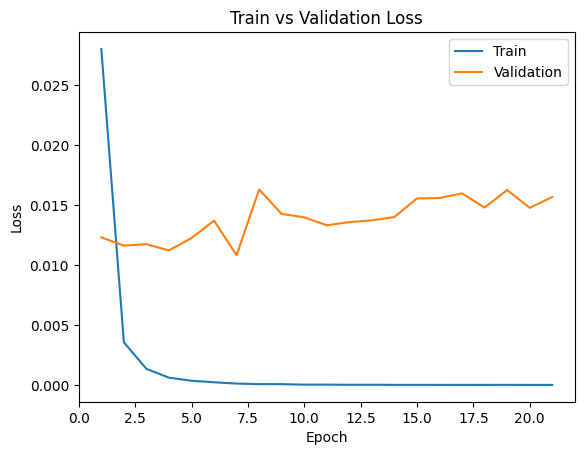

In [16]:
plot_training_curve("modelStorage/model_{0}_bs{1}_lr{2}_epoch{3}".format("fungaV1", BATCH_SIZE, LEARNING_RATE, 20))

In [17]:
#test accuracy function
def getAccuracy(net, loader):
  correct, count = 0, 0
  net.eval()
  #no gradient modification
  with torch.no_grad():
    print("Total number of batches: ", len(loader))
    for currbatch, (i, corr) in enumerate(loader):
      count += corr.shape[0]

      correct += (torch.max(net(i), 1)[1] == corr).sum().item()

  return correct / count

In [18]:
bestNet = preLearnedFungaV1()
model_path = get_model_name("fungaV1", batch_size=BATCH_SIZE, lr=LEARNING_RATE, epoch=(10))
state = torch.load(model_path)
bestNet.load_state_dict(state)

_,_, testLoad = dataLoadFunction(24)

dataLoad = testLoad

accuracy = getAccuracy(bestNet, dataLoad)
print("Test Classification Accuracy: ", accuracy)

Total number of batches:  54
Test Classification Accuracy:  0.8535630383711824
